# Time Series Intro

The goal of this notebook is to introduce the most common patterns, observed in time series, and the assumptions underlying most statistical time series models. It goes over commonly observed types of processes, how to recognize them, and what are some fitting models to forecast them.

 - introduce the statistical foundations underlying time series analysis and forecasting
 - gain familiarty with different types of time series
 - understand the building blocks of the more automized packages (auto-arima, fbprophet, etc)
 - develop an intuition about how to approach modelling a time series process and which models are more suitable
 - know what the hyperpar-s mean and, if possible, what are some reasonable bounds for them
 - get familiar with common visualization methods for time series data
 
**"I have seen the future and it is very much like the present, only longer."**

--Kehlog Albran, The Profit

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import statsmodels.api as sm
from scipy import stats
import pmdarima as pm
import random
import tbats

In [2]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
os_path = os.getcwd()
energy_df = pd.read_pickle(os.path.dirname(os_path)+'\\data\\energycons.pkl')

In [4]:
energy_df = energy_df['Load']

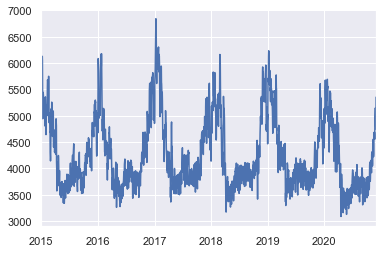

In [5]:
#aggregate to daily 
energy_df = energy_df.groupby(energy_df.index.strftime('%Y-%m-%d')).mean()
energy_df.index = pd.to_datetime(energy_df.index)

#split the dataset into test and train (note that for TS the temporal dimension matters, so we split based on time)
train = energy_df.loc[energy_df.index<'2020-12-01']
test = energy_df.loc[(energy_df.index>='2020-12-01')&(energy_df.index<'2021-01-01')]
train.plot();

# Descriptive statistics for TS/EDA

Think of the time series ($x_t$) as a **realization of a stochastic process**, described by a T-dimensional probability distribution; forecasts are therefore also random variables with confidence bands and *point estimates*. In standard statistics, we usually talk about a sample consisting of several, typically independent draws from the same distribution; in time series analysis we technically have just one observation (one trajectory).

We always start by plotting the data and observe the series for any consistent patterns or features. We can find four main types of patterns in a time series process:
 - trend
 - seasonality
 - cyclical
 - noise (random innovations)

 # Why should we care about EDA or the characteristics of our TS?
 
 - It can aid us to properly choose which models to try beforehand (helps us understand the data generating process).
  - Fbprophet is good for higher frequency seasonality but does not handle well lower frequency and cannot model ARMA processes
  - SARIMAX can only incorporate one type of seasonality and cannot be used for more complex seasonalities
  - SARIMAX cannot handle well higher frequency seasonality with a large lag; e.g. if we have daily data it will be fine estimating the weekly seasonality, but less so the annual one.
  - Random walks are not forecastable.
  - For multiple (complex) seasonality, we can use TBATS, FBProphet (depends), UCMs.
  - For data with high volatility (e.g. financial data), GARCH is likely to be a more suitable choice than most standardmodels.
 - Gives us information about the hyper-pars so we can decrease the running time of some automated models (e.g. ARIMA) by limiting the bounds over which we have to do the grid search.


## Examples of time series data
### White noise: $Z_t \sim WN(0, \sigma^2) $
The WN is a stationary and temporally non-correlated process. It is also the building block for other common types of time series we observe with a more complex autocorrelation structure.  

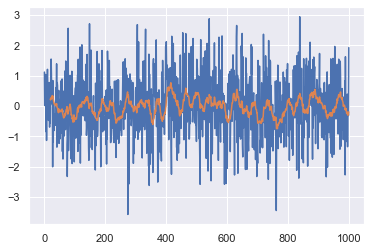

In [6]:
white_noise = pd.Series(np.random.randn(1000))
white_noise_ma = white_noise.rolling(20).mean()

plt.plot(white_noise);
plt.plot(white_noise_ma);

### Random walk: $X_t = \sum_{t = 1}^{T}Z_t$
Random walks are a common example of non-stationary processes. Some typical examples nonstationary series, driven by random walks, are stock prices and exchange rates. We usually have to apply some form of transformation to the raw series, in order to achieve stationarity.

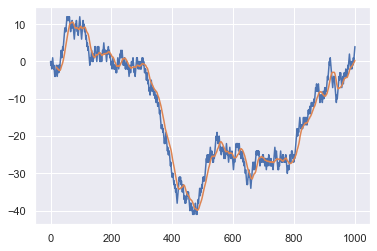

In [7]:
def simRandomWalk(prob, n):
    x = random.choices([-1 ,1], weights =[1-prob, prob], k=n)
    s = np.append([0], np.cumsum(x))
    return s

random_walk = pd.Series(simRandomWalk(0.5, 1000))
random_walk_ma = random_walk.rolling(20).mean()

plt.plot(random_walk);
plt.plot(random_walk_ma);

## AR(1) process: $X_t = Z_t + \theta X_{t-1}$

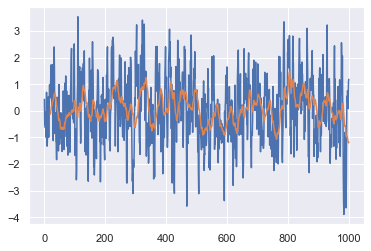

In [8]:
def simAR1 (alpha, N):
    normDist = stats.norm(0 , 1)
    x = normDist.rvs(N + 1)
    for i in range (N):
        x[i+1] = x[i+1] + alpha*x[i]
    return x

ar1_process = pd.Series(simAR1(0.6, 1000))
ar1_process_ma = ar1_process.rolling(20).mean()

plt.plot(ar1_process);
plt.plot(ar1_process_ma);

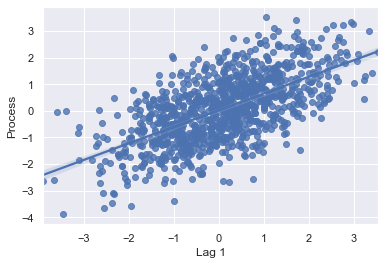

In [9]:
regplotdata = pd.DataFrame(ar1_process, columns=['Process'])
regplotdata['Lag 1'] = regplotdata['Process'].shift(1)
sns.regplot(x="Lag 1", y="Process", data=regplotdata);

## MA(1) process: $X_t = Z_t + \theta Z_{t-1}$

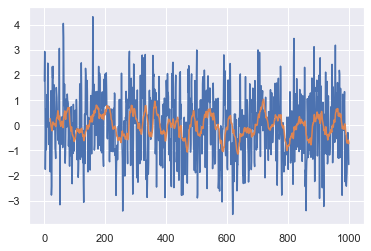

In [10]:
def simMA1(alpha, N):
    normDist = stats.norm(0,1)
    x = np.zeros((N))
    #draw innovations
    err = normDist.rvs(N)
    x[0] = err[0]
    for i in range (1, N):
        x[i] = err[i] + alpha*err[i-1]
    return x

ma1_process = pd.Series(simMA1(0.8, 1000))
ma1_process_ma = ma1_process.rolling(20).mean()

plt.plot(ma1_process);
plt.plot(ma1_process_ma);

## Trend with noise

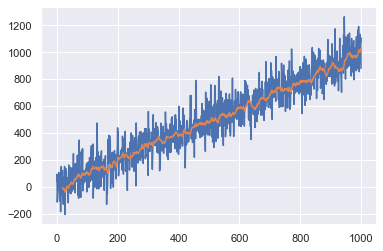

In [11]:
trend = np.arange(1000)
noise = np.random.randn(1000)*100
trend_wn = pd.Series(trend + noise)
trend_wn_ma = trend_wn.rolling(20).mean()

plt.plot(trend_wn);
plt.plot(trend_wn_ma);

## Seasonality with noise (our data for this notebook)

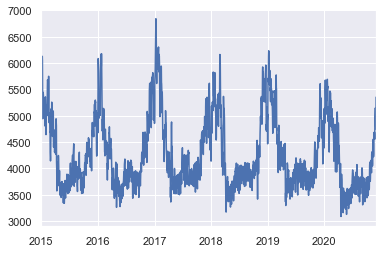

In [12]:
train.plot();

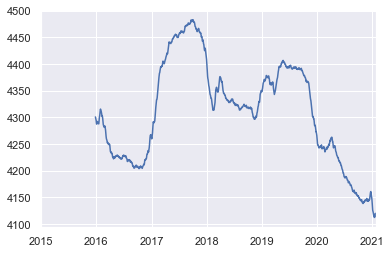

In [13]:
energy_df.rolling(360).mean().plot();

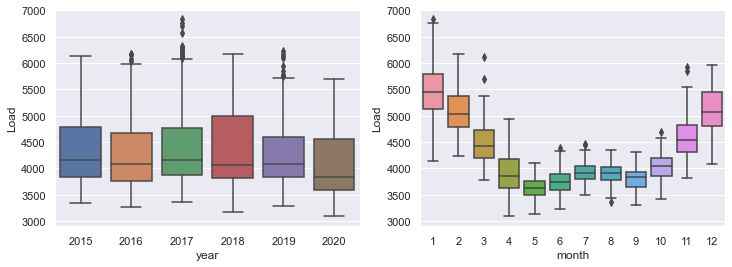

In [14]:
def plot_boxplots(series):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    sns_graph = pd.DataFrame(series).copy()
    sns_graph['year'] = sns_graph.index.year
    sns_graph['month'] = sns_graph.index.month

    sns.boxplot(x="year", y="Load", data=sns_graph, ax = axes[0]);
    sns.boxplot(x="month", y="Load", data=sns_graph, ax = axes[1]);

plot_boxplots(train)

# Time series data transformations

In order to make any meaningful statistical analysis, we need to assume that the observed part of the
stochastic process is typical for the time series as a whole. Two concepts are tightly related to this: *stationarity* and *ergodicity*.

There are some standard transformations that we often apply in order to ensure our assumptions are not violated. 
 - Distributional (also related to stationarity)
 - Stationarity inducing
 - Decompositional

# Distributional properties
We often need to apply some distributional transformations, as TS data can be skewed (for example often to the right, especially when the series is a measure of something that can only be positive).

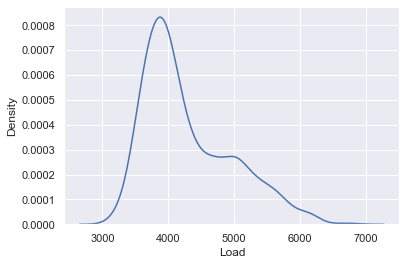

In [15]:
sns.kdeplot(train);

## Possible transformations 

### Logarithm
Transforming the data into logarthims is a common practice, since it reduces the variance and smoothes the mean. Note that all observations have to be larger than 0 (or we can add the same constant (*shift parameter*) to all observations if the data and task at hand allows it).
### Box-Cox transformation

\begin{equation*}
f^{BC}(x_t, \lambda) = \begin{cases}
\dfrac{({x_t}^\lambda - 1)}{\lambda} & \quad \lambda \neq 0, \\
\log x_t & \quad \lambda = 0.
\end{cases}
\end{equation*}


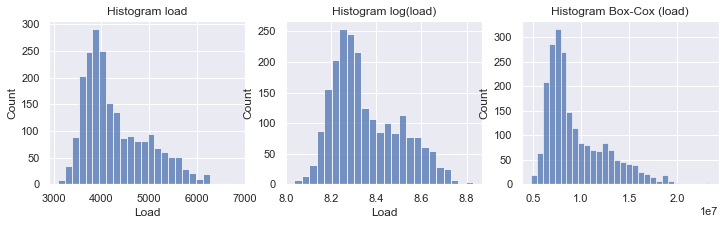

In [16]:
def plot_transformations_histograms(series, box_cox_lambda):
    fig, axes = plt.subplots(1, 3, figsize=(12,3))

    sns.histplot(series, ax = axes[0]);
    axes[0].set_title('Histogram load')

    sns.histplot(np.log(series), ax = axes[1]);
    axes[1].set_title('Histogram log(load)');

    sns.histplot(stats.boxcox(series, lmbda = box_cox_lambda), ax = axes[2]);
    axes[2].set_title('Histogram Box-Cox (load)');
    
plot_transformations_histograms(train, 2)

# Time Series Stationarity


### Ergodicity Assumption
Too complicated, lies within the ream of probability theory, but states that the observations of the stochastic process cover all possible events. 

### Stationarity
 
 - Weak stationarity implies:
  - 1st moment is constant over time
  - autocovariance is constant over time
  - 2nd moment is finite
 - Strict stationarity implies:
  - the unconditional joint probability distribution does not change over time
  


### Weak vs Strict Stationarity 
#### Does strict stationarity imply weak stationarity?
No. However if $E(X^2) < \infty$ for all $t$, then yes.
#### Does weak stationarity imply strict stationarity?
No. If we can assume joint normality however, the first two moments are enough to characterize the distribution, and weak stationarity implies strict stationarity as well.


### Trend vs Difference Stationarity
 - if a process needs to be differentiated d-times to arrive at stationarity, it is called integrated of order d, $X \sim I(d)$
 - if we need to eliminate a trend (by regressing the time series against a time polynomial of degree s), the series is trend-stationary
 - trend stationary process have a *deterministic trend*, whereas difference-stationary processes have a *stochastic trend*
 - long-term forecasts for the two are different (can you guess how?)
 
### Stationarity Tests

 - ADF test: $H_0$ = there is a unit root vs $H_\alpha$ = there isn't; different types of ADF:
  - no constant (drift) or trend in the OLS regression
  - constant (drift) in the OLS regression
  - constant (drift) and linear/quadratic trend
  - http://faculty.smu.edu/tfomby/eco6375/BJ%20Notes/ADF%20Notes.pdf
 - KPSS test:$H_0$ = the series is trend-stationary vs $H_\alpha$ = the series has a unit root
 - takeaways: stationarity test can sometimes give conflicting results; inference relies on proper specification of the test; cannot always be trusted? in auto arima models, results can vary depending on the stationarity test we choose

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(series, crit='BIC'):
    print_tests = 'Stationarity tests \n \
    P-values for: ADF with drift: {0:0.3f}, ADF drift and trend: {1:0.3f}, ADF no drift or trend: {2:0.3f} \n \
    KPSS p-value: {3:0.3f}'
    adftest_c = adfuller(series, autolag='BIC', regression = 'c')
    adftest_ct = adfuller(series, autolag='BIC', regression = 'ct')
    adftest_nc = adfuller(series, autolag='BIC', regression = 'nc')
    kpsstest = kpss(series)

    return print(print_tests.format(adftest_c[1], adftest_ct[1], adftest_nc[1], kpsstest[1]))

In [18]:
test_stationarity(white_noise, 'BIC')
test_stationarity(ar1_process, 'BIC')
test_stationarity(ma1_process, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100
Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100
Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100


In [19]:
test_stationarity(trend_wn, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.797, ADF drift and trend: 0.000, ADF no drift or trend: 0.934 
     KPSS p-value: 0.010


In [20]:
test_stationarity(random_walk, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.765, ADF drift and trend: 0.991, ADF no drift or trend: 0.377 
     KPSS p-value: 0.010


In [21]:
test_stationarity(train, 'BIC')

Stationarity tests 
     P-values for: ADF with drift: 0.005, ADF drift and trend: 0.033, ADF no drift or trend: 0.499 
     KPSS p-value: 0.100


# Autocorrelation and partial autocorrelation functions (ACF and PACF)

### ACF
We might observal "internal" correlations within time series, or in other words - autocorrelations between the current value $x_t$ and previous (lagged) values $x_{t-k}$ for $k = 1, 2 ... n$. We estimate the autocovariance of a stochastic process as follows: <br>
 
$\hat{\gamma}(h) = \dfrac{1}{T}\sum_{t = 1}^{T-h}(X_t - \bar{X}_T)(X_{t+h}-\bar{X}_T)$, where $\bar{X}_T$ is the sample mean. The autocorrelation function is then the following: <br>
$\hat{\rho}(h) = \dfrac{\hat{\gamma}(h)}{\hat{\gamma}(0)}$

If a time series is stationary, the autocovariance and respectively the ACF should depend only on the number of lags, but on the particular point of time. 




### PACF
The partial autocorrelation funciton measures how much $X_1$ contributes to a linear forecast of $X_{t+1}$, **controlling** for $X_{t}, X_{t-1}, ..., X_2$. Denote the best linear predictor of $X_{t+1}$ as: <br>
$\mathrm{P}_t X_{t+1} = \alpha_1 X_t + \alpha_2 X_{t-1} + ... + \alpha_t X$, then $\alpha+t$ can be seen as a measure of importance for the additional information contributed by $X_1$ (PACF). For AR(p) process, all the information is contained in the $p$ lags; for the MA(q) process however, we can identify the innovations $Z$ from all current and previous observations (they are all contributing) 


### Rule of thumb for 'guessing' lag orders of an ARMA process
Using the ACF and PACF can be incredinly useful for modeling ARMA process. It is a vital step of the [Box-Jenkins forecasting method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method), because they can be used to 'guess' the number of auto-regressive (p) and moving average (q) lags of the ARMA model. When using auto-arima packages, the ACF and PACF can be used both as a sanity check, or as a guide of what ranges to set for the grid search.

|  | ACF | PACF |
| --- | --- | --- |
| AR(p) process| decays exponentially (monotonically or oscillating to zero) | p lags |
| MA(q) process | q lags | decays exponentially (monotonically or oscillating to zero) |

In [22]:
def plot_acf_pacf(series, nlags):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sm.graphics.tsa.plot_acf(series, lags=nlags, ax = axes[0])
    axes[0].set_title('Sample ACF')

    sm.graphics.tsa.plot_pacf(series, lags=nlags, ax = axes[1])
    axes[1].set_title('Sample PACF')
    
    return fig

### White noise process ACF and PACF
The WN process is both stationary and temporally uncorrelated by definition - therefore the ACF should be 0 everywhere, but at lag $h=0$, where it equals 1. We can also say that WN is a process without memory.

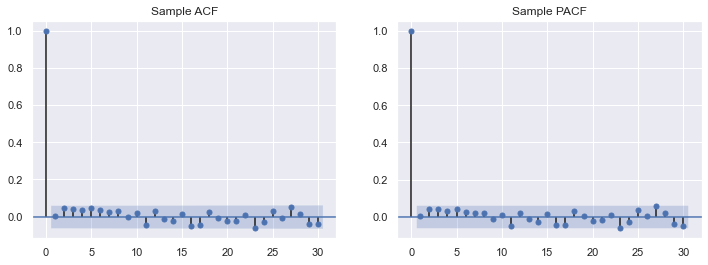

In [23]:
#White Noise
plot_acf_pacf(white_noise, 30);

### Trend with white noise 
The non-decreasing ACF hints that the process is not stationary.

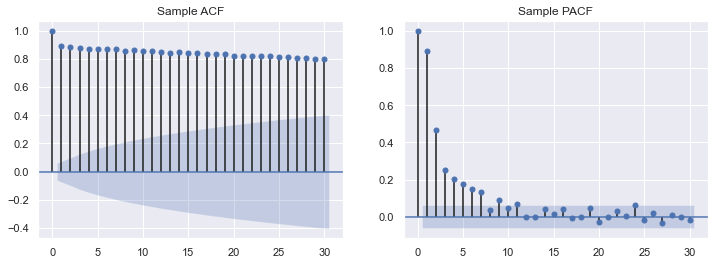

In [24]:
#Trend with white noise
plot_acf_pacf(trend_wn, 30);

### Random walk
ACF shows clear non-stationarity; in the PACF we can see the highly singificant first lag, with a coefficient close to 1.

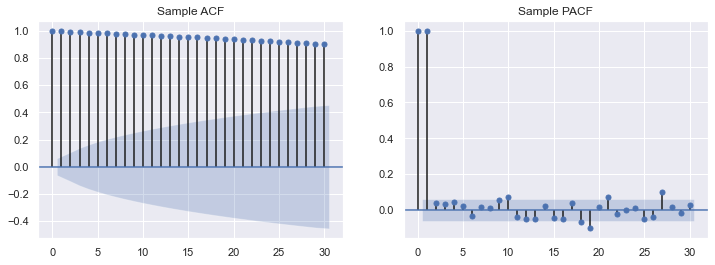

In [25]:
#Trend with white noise
plot_acf_pacf(random_walk, 30);

### AR(1) process
The ACF decays slowly, whereas in the PACF we can see only the first lag is significant; characteristic for an AR(1) process.

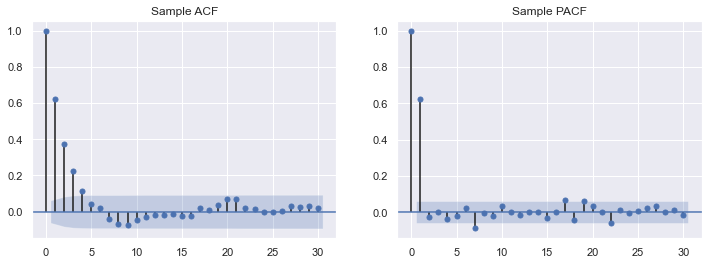

In [26]:
#AR(1) process
plot_acf_pacf(ar1_process, 30);

### MA(1) process
The PACF decays (in an oscillating manner) to 0, and the first lag of the ACF is significant - typical for an MA process.

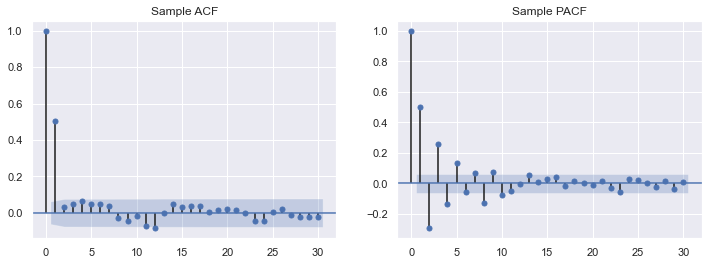

In [27]:
#MA(1) process
plot_acf_pacf(ma1_process, 30);

### Our data: energy consumption
We can see clear seasonality trend; the process reminds us also of a random walk.

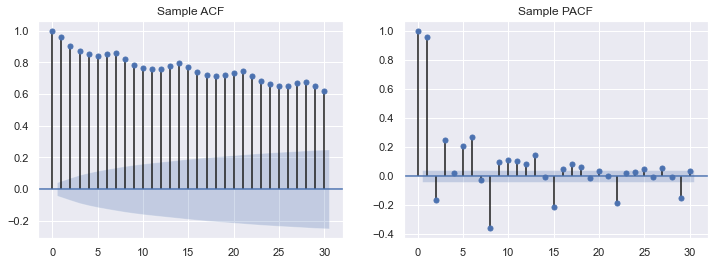

In [28]:
#Energy Data
plot_acf_pacf(train, 30);

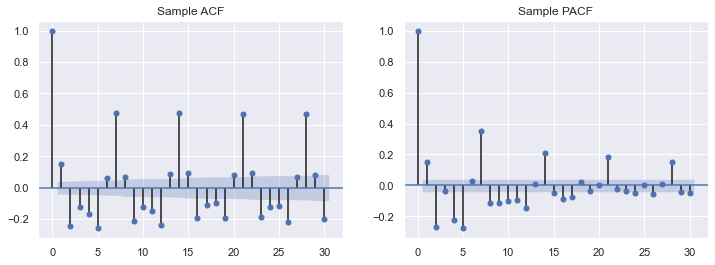

In [29]:
#Energy Data
plot_acf_pacf(train.diff().dropna(), 30);

# Seasonality in TS data

Time series often show seasonality: repeating patterns at regular intervals. Depending on the frequency at which the series is observed, the seasonality may vary. 
 - Quarterly data: seasonality happens usually every four quarters
 - Monthly\weekly\daily data: seasonality repeats every (close to) 12 month\52 weeks\365 days respectively.
 - We can also observe higher frequency seasonality: hours, minutes, etc.
 
The presence of seasonality is usually visible when we plot the time series; it can also be spotted in the sample ACF plots or in any other plot grouping the data by the seasonal frequency. 

### Complex Seasonality

When we work with higher frequency data (daily, hourly, minutes, etc) we are likely to find multiple seasonalities in the series. For example, energy consumption is likely to be influenced both by the day of the week and the specific month\season of the year.


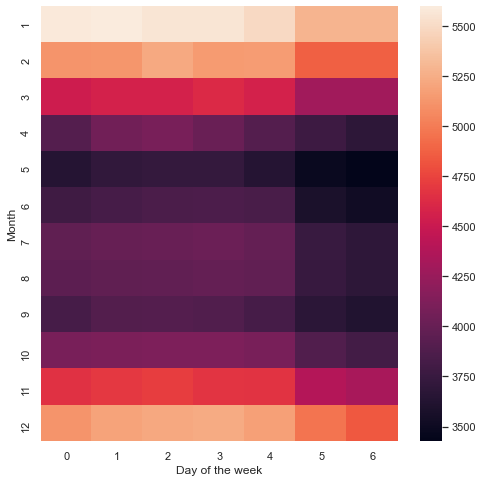

In [30]:
dfnew = pd.DataFrame(train.copy())
dfnew['Month'] = train.index.month
dfnew['Day of the week'] = train.index.weekday

dfnew = pd.pivot_table(dfnew, values='Load', index=['Month'],
                     columns=['Day of the week'], aggfunc=np.mean, fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(dfnew);

## Modeling Seasonality
### Deterministic vs Stochastic Seasonality

 - **Deterministic seasonality** assumes that the seasonal pattern is deterministic, in the sense that the seasonal means $\alpha_i$, $i = 1 ...  m$, remain constant through time; think of a regression with dummies for each season.
 - **Stochastic seasonality** suggests evolving seasonal patterns; modelled often using an ARIMA process. looking at the sample ACF can give us information about the type of seasonality: e.g. slowly decaying seasonality in SACF signals seasonal non-stationarity, which means it can be handled with seasonal differencing (SARIMAX; high frequency data issues due to increasing number of lags).
 - **Mixed seasonality**: “Pure” stochastic seasonality simply requires that no seasonal dummies are significant (we cannot reject the null of the means equal to zero)
 


### Additive vs Multiplicative Seasonality
 - Additive 
    $X_t = T_t + S_t + I_t$
 - Multiplicative
    $X_t = T_t \times S_t \times I_t$
 - [additive vs multiplicative seasonality game](https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/)    
***Note that the distinction becomes somewhat artificial if we take the logarithm of a multiplicative series.    


### OLS regression: deterministic seasonality
We can also run an OLS regression with dummies for the days of the week on the residuals (or months, season, we can include a trend, etc), and we can see the effect each weekday has on the total load. <br>
<br>
*note that because we are keeping the intercept, we are using six, rather than seven dummies, in order to avoid multicollinearity.

In [31]:
weekday_df = pd.DataFrame(train)
weekday_df['dayoftheweek'] = weekday_df.index.weekday
X = pd.get_dummies(weekday_df['dayoftheweek'], prefix='day', drop_first=True)

X = sm.add_constant(X)
model = sm.OLS(weekday_df['Load'], X)
results_ols_w = model.fit()
print(results_ols_w.summary())

                            OLS Regression Results                            
Dep. Variable:                   Load   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     12.48
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           7.20e-14
Time:                        09:34:21   Log-Likelihood:                -17112.
No. Observations:                2161   AIC:                         3.424e+04
Df Residuals:                    2154   BIC:                         3.428e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4331.7540     37.889    114.328      0.0

In [34]:
from statsmodels.tsa.deterministic import Fourier
fourier_gen = Fourier(365, order=1)
df_fourier = fourier_gen.in_sample(train.index)

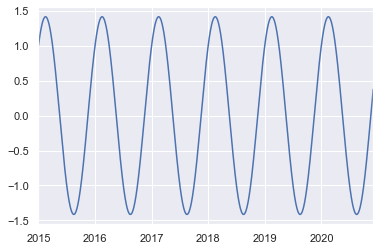

In [35]:
df_fourier.sum(axis = 1).plot();

In [36]:
model = sm.OLS(train, df_fourier.sum(axis = 1))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                   Load   R-squared (uncentered):                   0.008
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              17.99
Date:                Mon, 15 Mar 2021   Prob (F-statistic):                    2.31e-05
Time:                        09:34:41   Log-Likelihood:                         -21160.
No. Observations:                2161   AIC:                                  4.232e+04
Df Residuals:                    2160   BIC:                                  4.233e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Steps to estimate the MA seasonal adjustment decomposition
[statsmodels documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
1. Use MA to find the trend of the series
2. Substract the trend from the series: <br>
$X_{SA, I} = X_t - T_t = S_t + I_t$
3. Use the identifying assumption that $\bar{I_t} = 0$
4. $S_t$ then can be calculated as the average of each quarter, month, etc accross years.
5. Calculate $I_t$ as the residual.



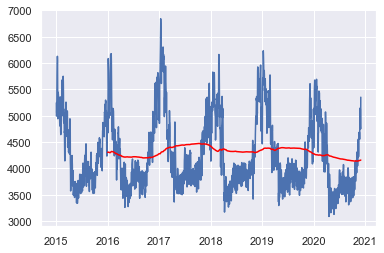

In [37]:
train_ma = train.rolling(365).mean()

plt.plot(train)
plt.plot(train_ma, color='red');

We estimate the centered (two-sided) moving average for the seasonality preiod (4 for quarterly data, 12 for monthly and others).

$\text{WMA}_t(2n+1) = \sum_{i = -n}^{n}w_i x_{t-i}$

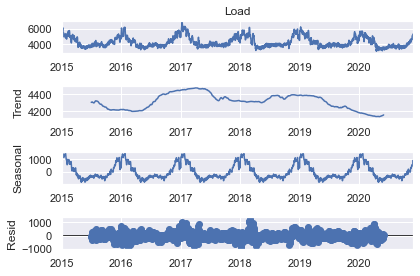

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
results_additive = seasonal_decompose(train, model='additive', period = 365)
results_additive.plot();

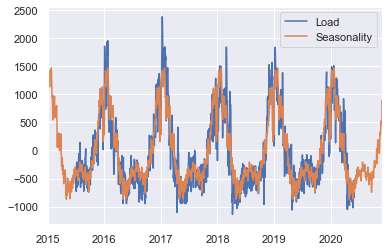

In [39]:
graph = pd.DataFrame(train - train.rolling(365, center=True).mean())
graph['Seasonality'] = results_additive.seasonal
graph.plot();

## Complex/Multiple seasonalities
Some series have more complex seasonality patterns. The daily electricity load, for example, has both annual and weekly seasonality. After extracting the annual seasonal component from the initial series, we can re-apply the the naive seasonality decomposition procedures to the residuals we have derived.

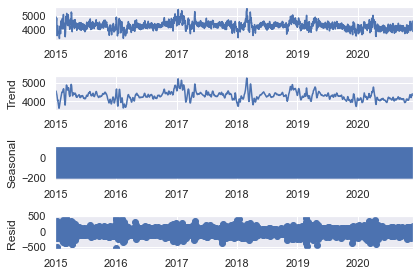

In [40]:
decomp_annual_df = train - results_additive.seasonal
results_additive_weekly = seasonal_decompose(decomp_annual_df, model='additive', period = 7)
results_additive_weekly.plot();

## STL decomposition
 - Seasonal-Trend decomposition using LOESS (STL)
 - Two main hyperpar-s to be chosen: trend-cycle window and seasonal window
 - [statsmodels example](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)

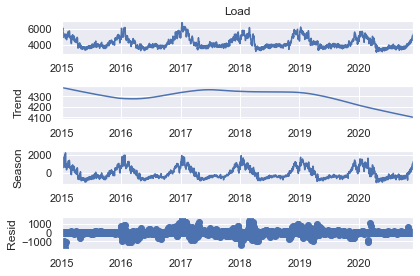

In [40]:
from statsmodels.tsa.seasonal import STL
stl = STL(train, period=365, robust=True)
res_STL = stl.fit()
fig = res_STL.plot()

### Spectral analysis using FFT (periodograms)
Every time series can be analyzed in the time domain or as overlayed waves of different frequencies (frequency domain). The decomposition of a time series into sinusoids of different frequencies is called the spectral representation. From a mathematical point of view, the equivalence between time and frequency domain analysis rest on the theory of Fourier series. The spectral density is defined as the Fourier transform of the ACF.
We can represent a signal by the magnitudes that each frequency contributes to the total signal. So, instead of plotting a signal versus  t , we can plot the magnitudes, or Fourier coefficients, of each frequency versus the frequency,  f . A plot like this is called a periodogram, and is useful to see what is present in the signal.
We can do much more with these magnitudes corresponding to frequencies. Say we wanted to filter out high frequency parts of the signal because they constitute noise. We could just go to the frequency domain, set the magnitudes for high frequencies to zero, and then go back to the time domain.

The Fourier transform is a useful mathematical tool to take us to the frequency domain and back, via the inverse Fourier transform. The fast Fourier transform, or FFT, is a very fact algorithm to do this, and it is implement in NumPy and SciPy. Furthermore, the scipy.signal module has many convenient functions for filtering in the frequency domain. We will make use of a Butterworth filter, which is one of the simplest frequency domain filters available.
https://online.stat.psu.edu/stat510/lesson/6/6.1
https://en.wikipedia.org/wiki/Nyquist_frequency

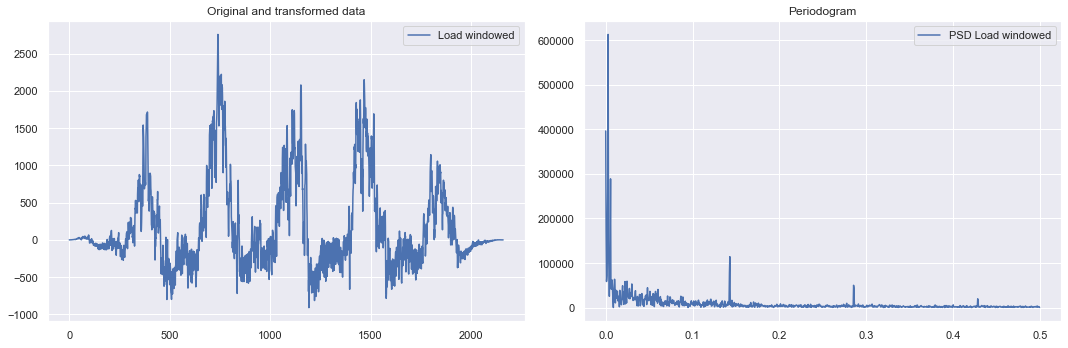

In [41]:
from numpy.fft import rfft, rfftfreq
from scipy.signal import tukey
from numpy.fft import fft, fftshift

def fft_tuckey_transform(series, d):
    t_series = np.linspace( 0, len(series)/1, len(series), endpoint=False )
    #note that the choice of window matters
    series_window = (series-np.median(series))*tukey(len(series))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    #ax[0].plot(t_series, series, label='Load')
    ax[0].plot(t_series, series_window, label='Load windowed' )
    ax[0].legend()
    ax[0].set_title('Original and transformed data')

    series_fft = abs(rfft(series))
    series_tukey = abs(rfft(series_window) )

    #set d to the inverse of the step (365 days in 1 year if you want to set for years)
    #currently set to days
    series_freqs = rfftfreq( len(series), d = 1/d)


    #ax[1].plot(series_freqs, series_fft, label='PSD Load' )
    ax[1].plot(series_freqs, series_tukey, label='PSD Load windowed' )
    ax[1].legend()
    ax[1].set_title('Periodogram')

    plt.tight_layout()
    plt.show()

fft_tuckey_transform(train, 1)

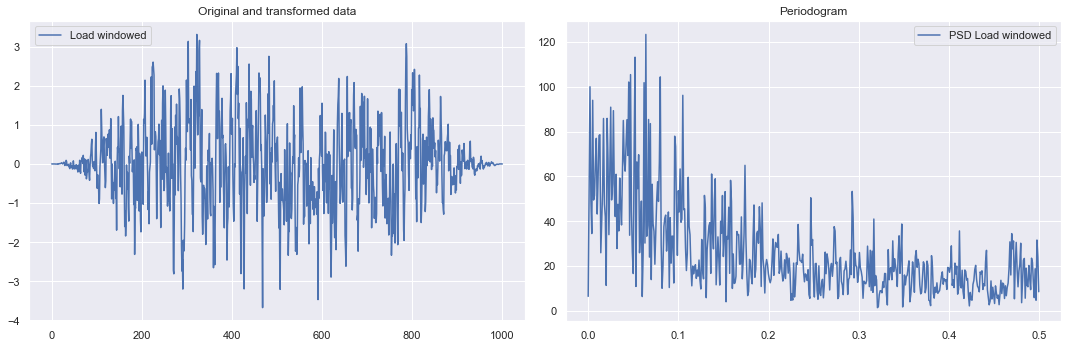

In [42]:
fft_tuckey_transform(ar1_process, 1)

### stationarity testing, SACF and SPACF post transformations

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.586 
     KPSS p-value: 0.017


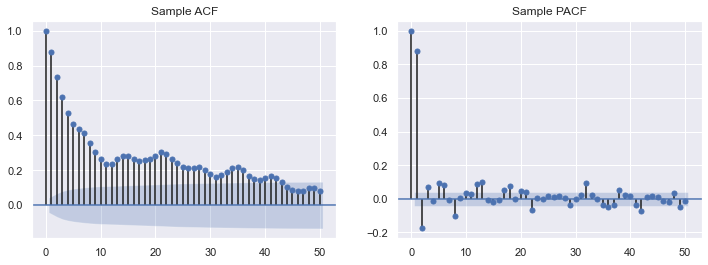

In [43]:
decomp_df = decomp_annual_df - results_additive_weekly.seasonal
test_stationarity(decomp_df)
plot_acf_pacf(decomp_df, nlags = 50);

Stationarity tests 
     P-values for: ADF with drift: 0.000, ADF drift and trend: 0.000, ADF no drift or trend: 0.000 
     KPSS p-value: 0.100


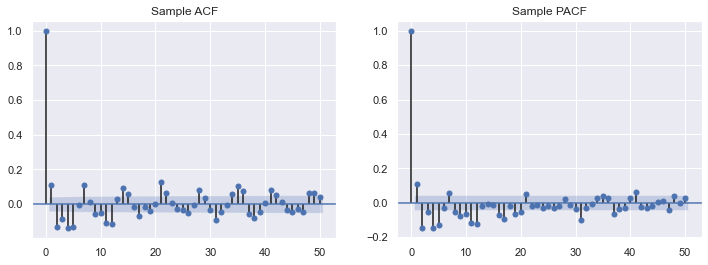

In [44]:
test_stationarity(decomp_df.diff().dropna())
plot_acf_pacf(decomp_df.diff().dropna(), nlags = 50);

# ARIMA (p, d, q) models (autoregressive, integrated, moving average)
ARIMA(1, 0, 1): $X_t = \phi X_{t-1} + \theta Z_{t-1}+Z{t}$

## Wald's Decomposition
Every weakly stationary, purely nondeterministic, stochastic process $x-\mu$ can be expressed as a linear combination of a sequence of random variables:
$x-\mu = a_t+\psi_1a_{t-1} + ... = \sum_{j = 0}^{\infty}\psi_j a_{t-j}$, where $a_t \sim WN(0, \sigma^2)$


- AR(p) models can be estimated by OLS (efficient estimator)
- ARMA(p, q) models are estimated using MLE, as the MA(q) process is not directly observed in the data
- ARMA can be used only on stationary, invertible and causal stochastic processes
- if the series is I(d), or integrated of order d, we can use the ARIMA(p, d, q) model




## Steps when modeling an ARMA/ARIMA process

#### Step 1: Transform the series to achieve stationarity
 - transform the series into log-s, difference or remove trend if necessary
 - remove seasonality
 
#### Step 2: Find the p and q order
 - investigate the sample ACF and PACF
 
#### Step 3: Diagnostics checking
 - observing the residuals from the fitted model for misspecifications such as
 - autocorrelated residuals (SACF), Ljung-Box test
 - overfit the model by including p+1/q+1 lags in order to check if they are significant
 - invesetigate out-of-sample performance of the mode, does it deliver sensible forecasts?


## Choosing lags (hyperpar-s) based on information criteria
- AIC: $AIC(p, q) = log\hat{\sigma}^2 + 2(p+q)T^{-1}$
- BIC: $BIC(p, q) = log\hat{\sigma}^2 + (p+q)T^{-1}logT$
- BIC is *strongly consistent*, or in other words chooses the 'true' model asymptotically, whereas AIC will choose an over-parametrized model (might be better for forecasting)

In [45]:
from statsmodels.tsa.ar_model import AutoReg
res = sm.tsa.arima.ARIMA(decomp_df, order=(10, 1, 10), enforce_stationarity=True).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2161
Model:               ARIMA(10, 1, 10)   Log Likelihood              -13406.345
Date:                Mon, 15 Mar 2021   AIC                          26854.690
Time:                        09:36:44   BIC                          26973.925
Sample:                    01-01-2015   HQIC                         26898.300
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1299      0.472      0.276      0.783      -0.794       1.054
ar.L2         -0.3641      0.485     -0.751      0.453      -1.314       0.586
ar.L3          0.7355      0.480      1.531      0.1

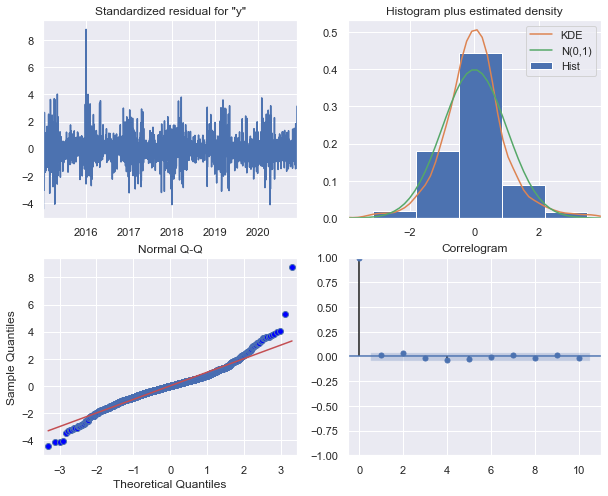

In [46]:
res.plot_diagnostics(figsize = (10, 8));

## ARCH/GARCH processes
ARCH and GARCH models are used to model time series data with heteroscedasticity. They are often used for financial time series, due to some stylized facts characterizing financial data such as clustered volatility and time-varying volatility. When the error variance follows an AR model, we use ARCH, and if it follows an ARMA - GARCH model.
[more information](https://online.stat.psu.edu/stat510/lesson/11/11.1)

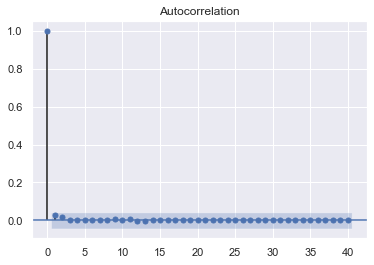

In [47]:
residuals = res.resid

sm.graphics.tsa.plot_acf(residuals**2, lags=40)
plt.show()

# Grid-search for tuning the ARIMA/SARIMA (seasonal ARIMA) hyperpar-s

In [48]:
from pmdarima.model_selection import train_test_split

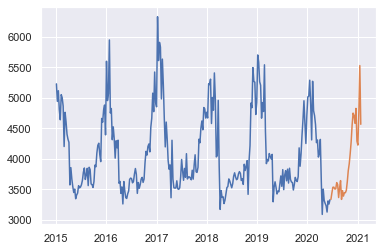

In [49]:
energy_weekly = energy_df.asfreq('w')
train_w, test_w = train_test_split(energy_weekly, train_size=int(0.9*len(energy_weekly)))
plt.plot(train_w)
plt.plot(test_w);

In [125]:
model = pm.auto_arima(train_w, start_p = 0, start_q = 0, 
                      max_p = 5, max_d = 2, max_q = 5, information_criterion='aic',
                      test = 'adf', max_P=2, max_D=1, max_Q=2, max_order=2, m=52, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)


Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(1,0,1,52) [intercept=True]; AIC=4319.704, BIC=4334.257, Time=20.238 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=True]; AIC=4437.751, BIC=4445.028, Time=0.026 seconds
Fit ARIMA(1,0,0)x(1,0,0,52) [intercept=True]; AIC=4069.614, BIC=4084.168, Time=13.379 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(0,0,1)x(0,0,1,52) [intercept=True]; AIC=4197.216, BIC=4211.770, Time=12.183 seconds
Fit ARIMA(0,0,0)x(0,0,0,52) [intercept=False]; AIC=5484.192, BIC=5487.830, Time=0.024 seconds
Fit ARIMA(1,0,0)x(0,0,0,52) [intercept=True]; AIC=4074.219, BIC=4085.134, Time=0.083 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,0,52) [intercept=True]; AIC=4061.045, BIC=4079.237, Time=296.096 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 0, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(1,0,1,52) [intercept=True]; AIC=4069.365, BIC=4087.556, Time=29.878 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(1,0,0)x(0,0,1,52) [intercept=True]; AIC=4071.819, BIC=4086.372, Time=4.464 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,1,52) [intercept=True]; AIC=4063.900, BIC=4085.730, Time=356.105 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(1,0,0)x(2,0,2,52) [intercept=True]; AIC=4064.817, BIC=4090.286, Time=631.962 seconds
Near non-invertible roots for order (1, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(1,0,2,52) [intercept=True]; AIC=4062.767, BIC=4084.597, Time=230.572 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(1,0,0)x(0,0,2,52) [intercept=True]; AIC=4067.265, BIC=4085.457, Time=211.894 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(0,0,0)x(1,0,2,52) [intercept=True]; AIC=4237.249, BIC=4255.441, Time=275.002 seconds
Near non-invertible roots for order (0, 0, 0)(1, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(1,0,2,52) [intercept=True]; AIC=4038.959, BIC=4064.428, Time=414.315 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,0)x(0,0,2,52) [intercept=True]; AIC=4042.773, BIC=4064.603, Time=325.665 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(1,0,1,52) [intercept=True]; AIC=4044.324, BIC=4066.154, Time=121.134 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,2,52) [intercept=True]; AIC=4041.832, BIC=4070.939, Time=373.794 seconds
Near non-invertible roots for order (2, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(2,0,0)x(0,0,1,52) [intercept=True]; AIC=4048.783, BIC=4066.974, Time=6.721 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(2,0,0)x(2,0,1,52) [intercept=True]; AIC=4040.183, BIC=4065.652, Time=775.851 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(1,0,2,52) [intercept=True]; AIC=4027.043, BIC=4056.150, Time=620.493 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,0)x(0,0,2,52) [intercept=True]; AIC=4031.627, BIC=4057.096, Time=188.744 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(1,0,1,52) [intercept=True]; AIC=4033.920, BIC=4059.388, Time=43.753 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(3,0,0)x(2,0,2,52) [intercept=True]; AIC=4031.203, BIC=4063.948, Time=896.201 seconds
Near non-invertible roots for order (3, 0, 0)(2, 0, 2, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA(3,0,0)x(0,0,1,52) [intercept=True]; AIC=4041.558, BIC=4063.388, Time=48.319 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py:399: ModelFitWarning: Error fitting ARIMA(3,0,0)x(2,0,1,52) [intercept=True] (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_auto_solvers.py", line 377, in _fit_arima
    fit = ARIMA(order=order, seasonal_order=seasonal_order,
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 470, in fit
    self._fit(y, exogenous, **fit_args)
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 395, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\arima.py", line 383, in _fit_wrapper
    return arima, arima.fit(start_params=start_p

Fit ARIMA(3,0,0)x(2,0,1,52) [intercept=True]; AIC=nan, BIC=nan, Time=nan seconds
Fit ARIMA(4,0,0)x(1,0,2,52) [intercept=True]; AIC=4029.402, BIC=4062.147, Time=329.981 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(3,0,1)x(1,0,2,52) [intercept=True]; AIC=4028.429, BIC=4061.174, Time=211.025 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fit ARIMA(2,0,1)x(1,0,2,52) [intercept=True]; AIC=4035.685, BIC=4064.792, Time=139.147 seconds


C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\GerganaMarkova\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Fit ARIMA(4,0,1)x(1,0,2,52) [intercept=True]; AIC=4031.486, BIC=4067.870, Time=190.963 seconds
Total fit time: 8786.641 seconds


In [82]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1534
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -9785.710
Date:                             Tue, 02 Feb 2021   AIC                          19587.420
Time:                                     17:10:02   BIC                          19630.105
Sample:                                          0   HQIC                         19603.304
                                            - 1534                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    686.3731    110.610      6.205      0.000     469.582     903.164
ar.L1         -0.3320      

In [141]:
forecast_mean_ci = model.predict(n_periods = len(test_w), return_conf_int=True) 
forecast = pd.DataFrame(forecast_mean_ci[0], index = test.index)
forecast.columns = ['Forecast']
forecast[['upper_ci','lower_ci']] = forecast_mean_ci[1]

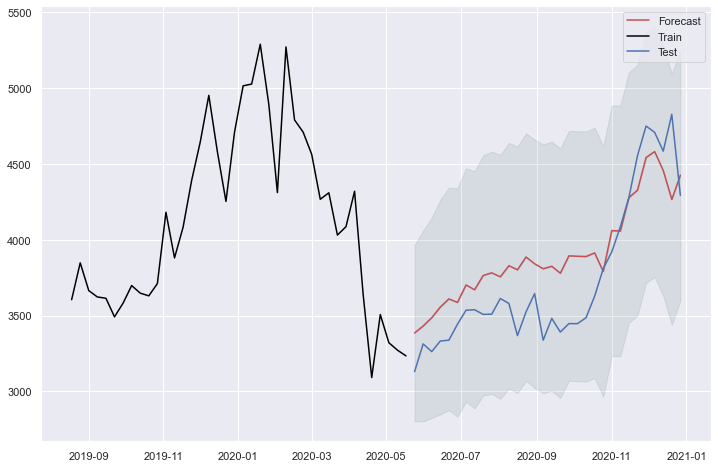

In [142]:
#graph
plt.figure(figsize=(12, 8))
plt.plot(forecast['Forecast'], color='r');
plt.plot(train_w.iloc[-40:], color='black')
plt.plot(test_w, color='b')
plt.fill_between(forecast.index, forecast['upper_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.fill_between(forecast.index, forecast['lower_ci'], forecast['Forecast'], alpha = 0.1, color='darkslategrey')
plt.legend(['Forecast', 'Train', 'Test']);

# Exponential Smoothing

Exponential smoothing views the process $X_t$ as a function of time: <br>
$X_t = f(t; \beta) + \varepsilon_t$ <br>
where $f(t; \beta)$ represents some polynomial in $t$ with coefficients $\beta$ (similar to a regression model with error model, specified as WN$(0, \sigma^2)$). Consider $f(t; \beta)$ to be a polynomial of order 0, then the process moves randomly around its mean $\beta$:<br>
$X_t = \beta + \varepsilon_t$ <br>
(what is then the best forecast of $X_t$?)

### Simple exponential smoothing
In many cases however, the mean does not remain constant, but is a slowly moving function of time. Then it becomes no longer reasonable to give each observation the same weight (in the constant mean case, our best forecast is the sample mean), but rather it is intuitive to give higher weights to recent observations than to older ones. We can then let the weights decline *exponentially*: <br>
$\mathbb{P}_T X_{T+1} = \dfrac{1-\omega}{1-\omega^T}\sum_{t=0}^{T-1}\omega^tX_{T-t}$, with $|\omega|<1$<br>
the value of $1-\omega$ is called the smoothing parameter, and it depends on the speed at which the mean changes. In the case the mean changes slowly, the value of $\omega$ should be large, and vice versa (why?).

For a large $T$, we can disregard $\omega^T$, and then we reach the simple exponential smoothing projection formula:<br>
$\mathbb{P}_T X_{T+1} = (1-\omega)[X_T+\omega X_{T-1}+\omega^2 X_{T-2} ... ] = (1-\omega)X_T+\omega\mathbb{P}_{T-1}X_{T}$

We can therefore estimate using recursion; we can set $\omega$ a priori (usually between 0.7 and 0.95), or choose a value which minimizes the mean squared one-period forecast error.

What type of processes can we use exponential smoothing?


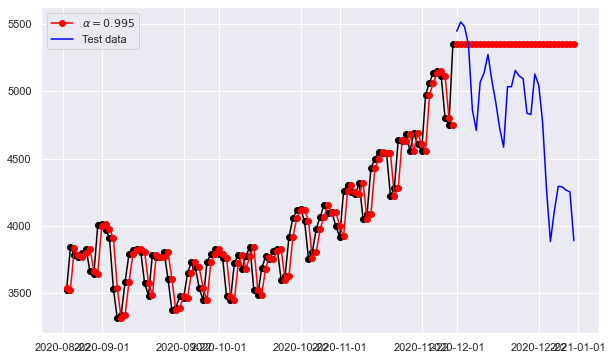

In [50]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit(optimized=True)
fcast_ses = fit_ses.forecast(31).rename(r'$\alpha=%s$'%fit_ses.model.params['smoothing_level'])

plt.figure(figsize=(10, 6))
plt.plot(train.iloc[-100:], marker='o', color='black')
plt.plot(fit_ses.fittedvalues.iloc[-100:], marker='o', color='red')
line1, = plt.plot(fcast_ses, marker='o', color='red')
line2, = plt.plot(test,  color='blue')

plt.legend([line1, line2,], [fcast_ses.name, 'Test data']);

### Holt's Method
Holt's Method (or triple exponential smoothing) applies smoothing three times: level (similar to SES), trend-, and seasonal-wise, with three different smoothing parameters. Depending on the type of seasonality in the process, it can be additive or multiplicative.


*we can also 'damp' the linear trend to a flat line in the future, using the dampening parameter<br>
*[for exponential trend](https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.Holt.html)

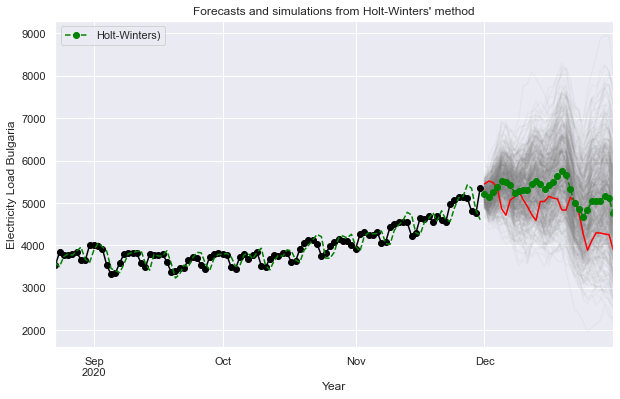

In [51]:
fit = ExponentialSmoothing(train, trend='mul', seasonal_periods=365, damped_trend=True,
                           seasonal='mul', initialization_method="estimated").fit()
simulations = fit.simulate(31, anchor='2020-12-01', repetitions=500,  random_errors='bootstrap')

ax = train.iloc[-100:].plot(figsize=(10,6), marker='o', color='black',
               title="Forecasts and simulations from Holt-Winters' method" )
ax.set_ylabel("Electricity Load Bulgaria")
ax.set_xlabel("Year")
fit.fittedvalues.iloc[-100:].plot(ax=ax, style='--', color='green')
simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
test.rename('Test data').plot(ax=ax, style='-',  color='red')
fit.forecast(31).rename('Holt-Winters)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
plt.show()

In [52]:
print(fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     Load   No. Observations:                 2161
Model:             ExponentialSmoothing   SSE                       75614658.470
Optimized:                         True   AIC                          23350.185
Trend:                   Multiplicative   BIC                          25451.166
Seasonal:                Multiplicative   AICC                         23505.393
Seasonal Periods:                   365   Date:                 Mon, 15 Mar 2021
Box-Cox:                          False   Time:                         10:10:48
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950000                alpha                 True
smoothing_trend       

# Theta model
 - [statsmodels example](https://www.statsmodels.org/devel/examples/notebooks/generated/theta-model.html)
 - [unmasking the Theta method](https://robjhyndman.com/papers/Theta.pdf)   

In [42]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(train)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                   Load   No. Observations:                 2161
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Thu, 11 Mar 2021   Deseas. Method:         Multiplicative
Time:                        15:34:49   Period:                              7
Sample:                    01-01-2015                                         
                         - 11-30-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    -0.12454989628686665
alpha   0.9998425584520849
--------------------------


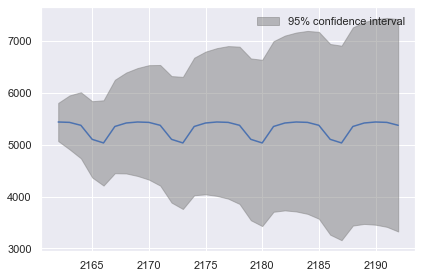

In [45]:
res.plot_predict(31, theta=1);

# TBATS and BATS

Exponential smoothing however does not handle multiple seasonalities; TBATS and BATS can handle complex seasonal time series such as those with multiple seasonal periods, high-frequency seasonality, non-integer seasonality, and dual-calendar effects.
 - Box-Cox transformations
 - Fourier representations with time-varying coefficients
 - ARMA error correction

[paper](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771)

In [36]:
from tbats import TBATS, BATS

In [37]:
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model_tbats = estimator.fit(train)

print(model_tbats.summary())

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [  7.   365.25]
Seasonal harmonics [ 3 11]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 1.200969
Trend (Beta): -0.278668
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-1.32568235e-06 -2.61156242e-07  1.55314729e-07  8.84613977e-07]
AR coefficients []
MA coefficients []
Seed vector [ 8.44190498e+00  1.16643895e-03  2.57059715e-02  9.17040026e-04
 -3.45493015e-03 -2.70476224e-02  1.77694264e-02 -5.14264659e-03
  1.78908752e-01  6.62570324e-02 -8.25654778e-03 -6.11966431e-04
 -4.95023704e-03 -1.01720567e-02 -1.07194704e-02 -6.29801187e-03
 -2.02674465e-03 -4.97857007e-03 -1.02964829e-02  1.42323906e-02
  3.90336237e-02 -1.66627774e-02 -1.52573011e-03  4.83664853e-03
  1.51094658e-03  2.49617131e-03  6.08912549e-03  1.52855168e-02
  8.55600507e-03  9.35490122e-03]

AIC 37626.836645


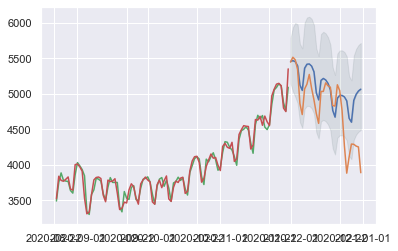

In [106]:
forecast_tbats = pd.DataFrame(model_tbats.forecast(steps=len(test), confidence_level=0.95)[1], index = test.index)
plt.plot(forecast_tbats['mean'], label='TBATS')
plt.plot(test, label = 'Test');
plt.plot((pd.DataFrame(model_tbats.y_hat, index = train.index).iloc[-100:]))
plt.plot((train.iloc[-100:]))
plt.fill_between(test.index, forecast_tbats['lower_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey')
plt.fill_between(test.index, forecast_tbats['upper_bound'], forecast_tbats['mean'], alpha = 0.1, color='darkslategrey');

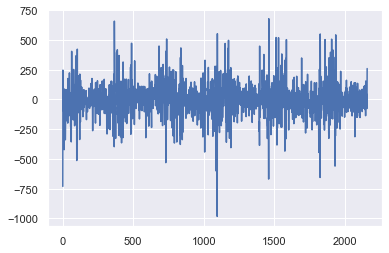

In [107]:
plt.plot(model_tbats.resid);

# Unobserved Components Model
UCMs are a class of structural time series models that decompose a series into trend, seasonal, cyclical, and irregular components. They are the backbone of most time series model, and offer a flexible framework for modelling different and complex processes. UCMs can also be cast into [state space form](https://www.stat.tamu.edu/~suhasini/teaching673/introduction.pdf), and then solved using the powerful [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter).

                                 Unobserved Components Results                                 
Dep. Variable:                                       y   No. Observations:                 2161
Model:                                 fixed intercept   Log Likelihood              -14474.242
                      + stochastic freq_seasonal(7(1))   AIC                          28952.484
                   + stochastic freq_seasonal(365(16))   BIC                          28963.808
Date:                                 Thu, 11 Mar 2021   HQIC                         28956.629
Time:                                         14:26:50                                         
Sample:                                              0                                         
                                                - 2161                                         
Covariance Type:                                   opg                                         
                                   coef 

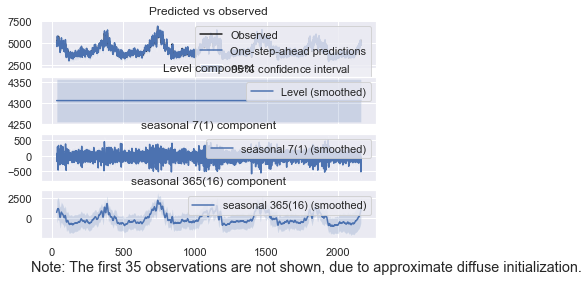

In [38]:
model = sm.tsa.UnobservedComponents(train.values,
                                    level = 'fixed intercept',
                                    freq_seasonal=[{'period': 7,
                                                    'harmonics': 1},
                                                    {'period': 365,
                                                     'harmonics': 16}])
res_f = model.fit(disp=False)
# The first state variable holds our estimate of the intercept
print(res_f.summary())
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

In [39]:
from datetime import datetime
def plot_forecast(series, resultsclass, start_date, end_date, dynamic):
    #get datetime fron the string dates
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    #new index for the foreacast df
    new_index = pd.date_range(start_date_dt, end_date_dt)
    #calculate int indices
    index_start_date = series.index.get_loc(start_date)
    index_end_date = index_start_date + len(new_index)-1
    #get the forecast
    df = resultsclass.get_prediction(index_start_date, index_end_date, dynamic).summary_frame()
    df.index = new_index
    #graph
    plt.figure(figsize=(12, 8))
    plt.plot(df['mean'], color='r');
    plt.plot(series.loc[series.index>start_date], color='black')
    plt.fill_between(df.index, df['mean_ci_lower'], df['mean'], alpha = 0.1, color='darkslategrey')
    plt.fill_between(df.index, df['mean_ci_upper'], df['mean'], alpha = 0.1, color='darkslategrey')
    
    return()

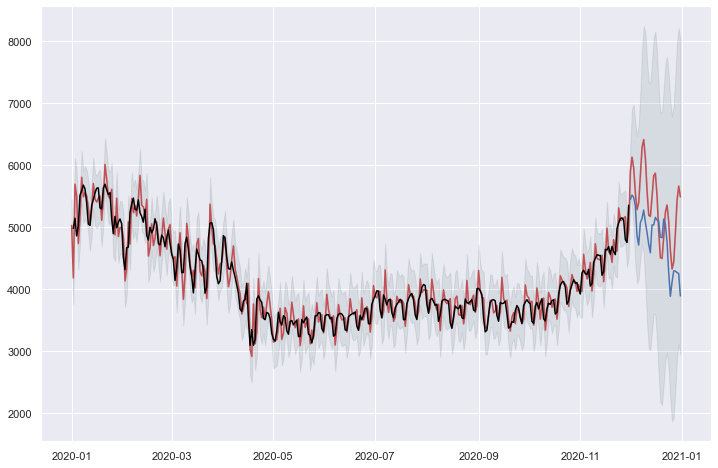

In [40]:
plot_forecast(train, res_f, '2020-01-01', '2020-12-31', False);
plt.plot(test);